In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adamax
from keras.losses import MeanSquaredError
from keras.activations import relu
import os
sns.set()
from keras.utils import plot_model


In [22]:
df = yf.download('TSLA','2010-06-29','2019-05-28',interval='1d')     # download the dataset from yahoo services

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [23]:
df.shape

(2242, 5)

In [24]:
df

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2010-06-29,1.592667,1.666667,1.169333,1.266667,281494500
2010-06-30,1.588667,2.028000,1.553333,1.719333,257806500
2010-07-01,1.464000,1.728000,1.351333,1.666667,123282000
2010-07-02,1.280000,1.540000,1.247333,1.533333,77097000
2010-07-06,1.074000,1.333333,1.055333,1.333333,103003500
...,...,...,...,...,...
2019-05-20,13.690667,13.733333,13.016667,13.520000,307893000
2019-05-21,13.672000,13.826667,13.069333,13.184000,270058500


In [25]:
df = df['Open'].values
print("Total No. of days of TSLA's Stocks :",df.shape[0])

Total No. of days of TSLA's Stocks : 2242


In [26]:
pd.DataFrame(df)

,0
0,1.266667
1,1.719333
2,1.666667
3,1.533333
4,1.333333
...,...
2237,13.520000
2238,13.184000
2239,13.273333
2240,12.956000


In [27]:
dataset_train = np.array(df[:int(df.shape[0]*0.8)])           ### Split the data into train and test sets considering overlapping (50 days )
dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])
print('Training stock :',dataset_train.shape[0],'days')
print('Test stock :',dataset_test.shape[0],'days')

Training stock : 1793 days
Test stock : 499 days


In [28]:
len(dataset_train) + len (dataset_test)

2292

In [29]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train.reshape(-1, 1))
dataset_test = scaler.transform(dataset_test.reshape(-1, 1))

In [30]:
def create_dataset(df,n):   # n is the prediction interval   50   50    0 --->50 , 1---->51  , 2----->52
    x = []
    y = []
    for i in range(n, df.shape[0]):
        x.append(df[i-n:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [31]:
x_train, y_train = create_dataset(dataset_train,50)
x_test, y_test = create_dataset(dataset_test,50)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [32]:
print('Training data shape',x_train.shape)
print('Test data shape',x_test.shape)

Training data shape (1743, 50, 1)
Test data shape (449, 50, 1)


In [33]:
x_train.shape[1]  ### Number of features in the data set used by the model

50

In [34]:
### LSTM Model for stock prediction
model = Sequential()
model.add(LSTM(units=96,return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
### O/P Layer (Full connected part)
model.add(Dense(units=1))

C:\Users\Mohammad\anaconda3\New folder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 50, 96)              │          37,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50, 96)              │          74,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50, 96)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 50, 96)              │          74,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 96)                  │          74,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              97 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 260,065 (1015.88 KB)

 Trainable params: 260,065 (1015.88 KB)

 Non-trainable params: 0 (0.00 B)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [36]:
model.compile(loss=MeanSquaredError, optimizer=Adamax(0.001))

In [37]:
history = model.fit(x_train,y_train,batch_size=32,epochs=70,verbose=1,validation_split=0.05)

Epoch 1/70
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.0374 - val_loss: 0.0141
Epoch 2/70
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0034 - val_loss: 0.0104
Epoch 3/70
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0029 - val_loss: 0.0153
Epoch 4/70
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0027 - val_loss: 0.0117
Epoch 5/70
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0024 - val_loss: 0.0131
Epoch 6/70
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0025 - val_loss: 0.0089
Epoch 7/70
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.0024 - val_loss: 0.0066
Epoch 8/70
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0025 - val_loss: 0.0112
Epoch 9/70
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0022 - val_loss: 0.0137
Epoch 10/70
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0021 - val_loss: 0.0124
Epoch 11/70
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0020 - val_loss: 0.0148
Epoch 12/70
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


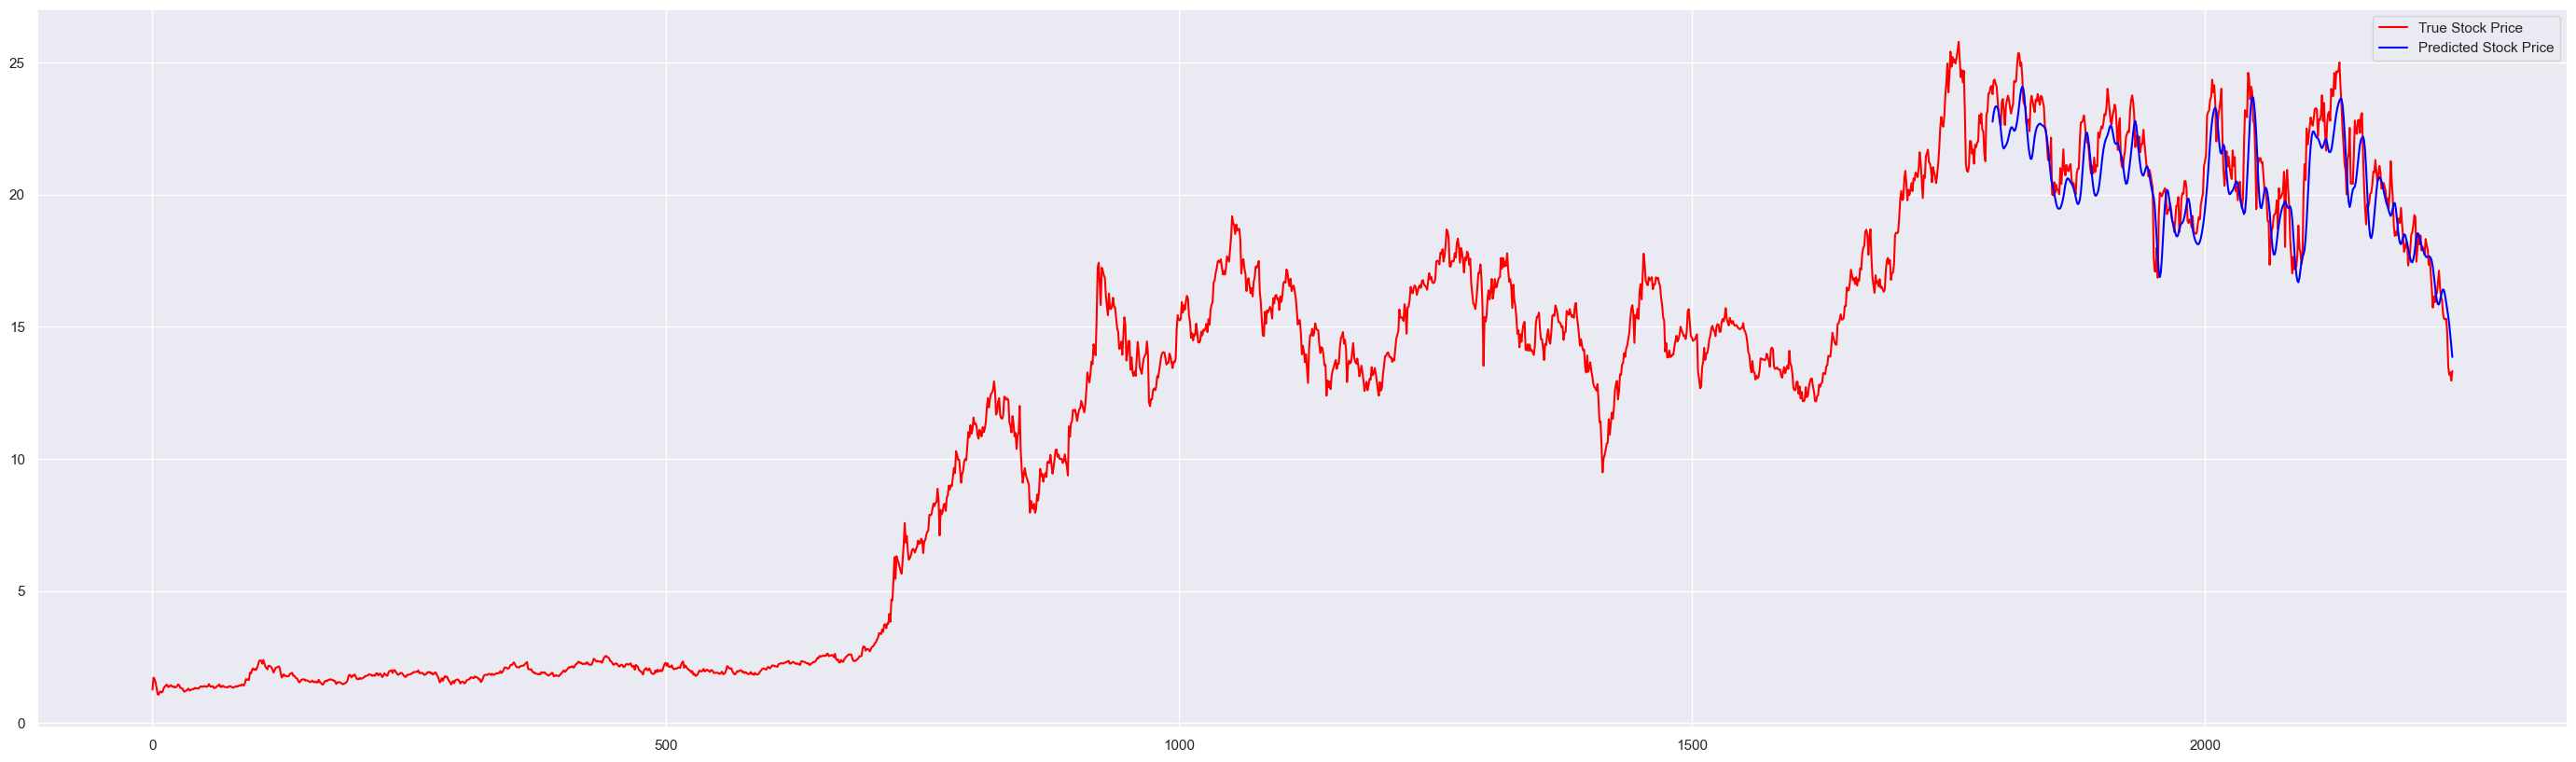

In [38]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
fig, ax = plt.subplots(figsize=(35,10))
plt.plot(df, color='red',  label="True Stock Price",)
ax.plot(range(len(y_train)+50,len(y_train)+50+len(predictions)),predictions, color='blue', label='Predicted Stock Price')
plt.legend()

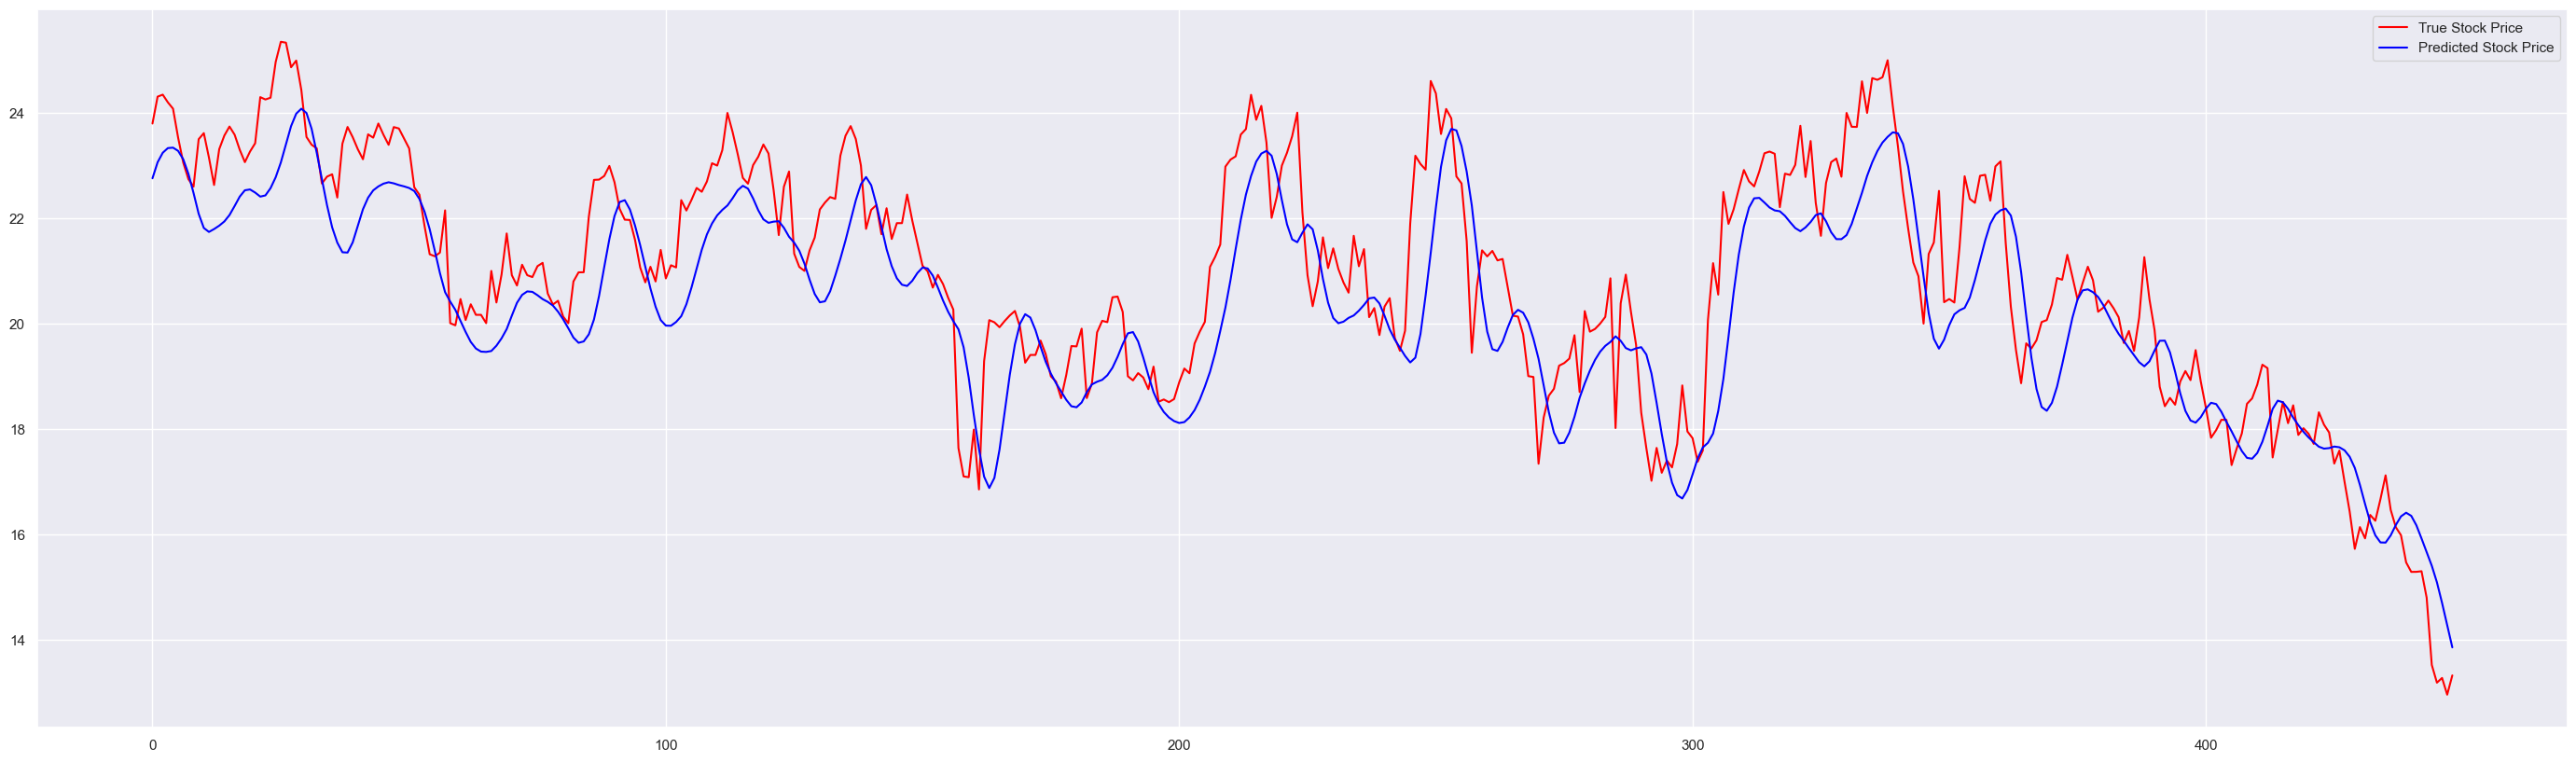

In [39]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
fig, ax = plt.subplots(figsize=(35,10))
ax.plot(y_test_scaled, color='red', label='True Stock Price')
plt.plot(predictions, color='blue', label='Predicted Stock Price')
plt.legend()